# Transfer learning
Using tensorflow hub

In [26]:
import cv2 
import tensorflow as tf
from tensorflow.python import keras
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import random

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()


api.dataset_download_files('pranavraikokte/covid19-image-dataset', path="./Images/", unzip=True)
del api

In [4]:
paths = ["./Images/Covid19-dataset/train/", "./Images/Covid19-dataset/test/"]
classes = os.listdir(paths[0])

In [5]:
data = []
for i,path in enumerate(paths):
    for num, str_label in enumerate(classes):
        filenames =  glob.glob( path + str_label +  '/*.jpg') + glob.glob( path + str_label +  '/*.jpeg') + glob.glob( path + str_label +  '/*.png')

        for filename in filenames:
            img = cv2.imread(filename)
            data.append([num, cv2.resize(img, (224,224))])
            del img
print("Number of elements: {}".format(len(data)))

Number of elements: 317


Divide dataset into $80\%$ Training, $10\%$ Validation and $10\%$ Testing

In [6]:
random.Random(0).shuffle(data)

X_train , Y_train = [],[]
X_val , Y_val = [],[]
X_test , Y_test = [],[]


for i, label_and_img in enumerate(data):

    if i < 0.8*len(data):
        X_train.append(label_and_img[1])
        Y_train.append(label_and_img[0])
    elif i > 0.8*len(data) <= 0.9*len(data):
        X_val.append(label_and_img[1])
        Y_val.append(label_and_img[0])
    else:
        X_test.append(label_and_img[1])
        Y_test.append(label_and_img[0])

del data

In [7]:
X_train = np.array(X_train)
X_val = np.array(X_train)
X_test = np.array(X_train)

Y_train = np.array(Y_train)
Y_val = np.array(Y_train)
Y_test = np.array(Y_train)  

#### One-Hot encoding

In [8]:
Y_train_onehot = tf.one_hot(Y_train, len(classes))
Y_val_onehot = tf.one_hot(Y_val, len(classes))
Y_test_onehot = tf.one_hot(Y_test, len(classes))

In [9]:
from keras.models import Sequential
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Dense
from keras.optimizers import Adam

In [10]:
model = Sequential([
   Convolution2D(32, (3,3), input_shape=(224,224,3), activation = 'relu'),
   MaxPooling2D(pool_size=(2,2)),
   Flatten(),
   Dense(30, activation='relu'),
   Dense(3, activation='softmax')
])

model.compile(optimizer="ADAMAX", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 30)                11828190  
                                                                 
 dense_1 (Dense)             (None, 3)                 93        
                                                                 
Total params: 11,829,179
Trainable params: 11,829,179
Non-trainable params: 0
____________________________________________

In [12]:
model.fit(X_train, Y_train_onehot, epochs=40, batch_size=200, validation_data=[X_val, Y_val_onehot])

Epoch 1/40
2/2 [==============================] - 1s 127ms/step - loss: 1.0949 - accuracy: 0.4370 - val_loss: 1.0949 - val_accuracy: 0.4370
Epoch 2/40
2/2 [==============================] - 0s 89ms/step - loss: 1.0949 - accuracy: 0.4370 - val_loss: 1.0948 - val_accuracy: 0.4370
Epoch 3/40
2/2 [==============================] - 0s 89ms/step - loss: 1.0948 - accuracy: 0.4370 - val_loss: 1.0948 - val_accuracy: 0.4370
Epoch 4/40
2/2 [==============================] - 0s 88ms/step - loss: 1.0948 - accuracy: 0.4370 - val_loss: 1.0947 - val_accuracy: 0.4370
Epoch 5/40
2/2 [==============================] - 0s 87ms/step - loss: 1.0947 - accuracy: 0.4370 - val_loss: 1.0947 - val_accuracy: 0.4370
Epoch 6/40
2/2 [==============================] - 0s 87ms/step - loss: 1.0946 - accuracy: 0.4370 - val_loss: 1.0946 - val_accuracy: 0.4370
Epoch 7/40
2/2 [==============================] - 0s 90ms/step - loss: 1.0946 - accuracy: 0.4370 - val_loss: 1.0946 - val_accuracy: 0.4370
Epoch 8/40
2/2 [==========

In [13]:
model.evaluate(X_test, Y_test_onehot)

8/8 [==============================] - 0s 15ms/step - loss: 1.0930 - accuracy: 0.4370


[1.09296452999115, 0.437007874250412]

### Transfer Learning

In [15]:
del model

!pip install tensorflow_hub
import tensorflow_hub as hub

In [16]:
path_to_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

model = Sequential([
   hub.KerasLayer(path_to_model, trainable=False),
   Dense(30, activation='relu'),
   Dense(3, activation='softmax')
])

model.compile(optimizer="ADAMAX", loss='categorical_crossentropy', metrics=['accuracy'])

model.build([None, 224, 224, 3])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 30)                38430     
                                                                 
 dense_3 (Dense)             (None, 3)                 93        
                                                                 
Total params: 2,296,507
Trainable params: 38,523
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
model.fit(X_train, Y_train_onehot, epochs=40, batch_size=200, validation_data=[X_val, Y_val_onehot])

Epoch 1/40
2/2 [==============================] - 3s 602ms/step - loss: 1.3417 - accuracy: 0.3031 - val_loss: 1.0612 - val_accuracy: 0.5079
Epoch 2/40
2/2 [==============================] - 0s 202ms/step - loss: 1.0490 - accuracy: 0.5236 - val_loss: 0.9461 - val_accuracy: 0.5630
Epoch 3/40
2/2 [==============================] - 0s 202ms/step - loss: 0.9381 - accuracy: 0.5669 - val_loss: 0.8584 - val_accuracy: 0.6024
Epoch 4/40
2/2 [==============================] - 0s 198ms/step - loss: 0.8536 - accuracy: 0.6181 - val_loss: 0.8057 - val_accuracy: 0.7047
Epoch 5/40
2/2 [==============================] - 0s 200ms/step - loss: 0.8011 - accuracy: 0.7008 - val_loss: 0.7587 - val_accuracy: 0.7441
Epoch 6/40
2/2 [==============================] - 0s 198ms/step - loss: 0.7541 - accuracy: 0.7480 - val_loss: 0.7095 - val_accuracy: 0.7441
Epoch 7/40
2/2 [==============================] - 0s 201ms/step - loss: 0.7054 - accuracy: 0.7362 - val_loss: 0.6726 - val_accuracy: 0.7126
Epoch 8/40
2/2 [====

In [18]:
model.evaluate(X_test, Y_test_onehot)

8/8 [==============================] - 0s 21ms/step - loss: 0.2690 - accuracy: 0.9528


[0.26903948187828064, 0.9527559280395508]

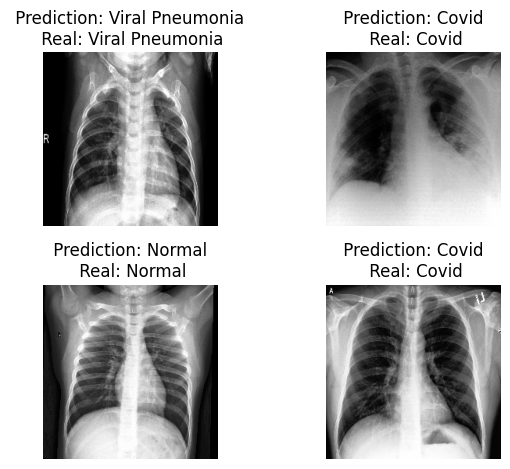

In [25]:
fig, axs = plt.subplots(2, 2)

for i in range(2):
    for j in range(2):
        rand_img = random.randint(0,X_test.shape[0]-1)
        predict = model.predict(np.array([X_test[rand_img]]), verbose=0)
        predict = np.argmax(predict)

        axs[i][j].imshow(X_test[rand_img])
        axs[i][j].set_title(" Prediction: {} \n Real: {}".format(classes[predict], classes[Y_test[rand_img]]))
        axs[i][j].axis('off')
plt.tight_layout()
plt.show()